#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_blobs, make_moons
from sklearn.preprocessing import StandardScaler

#### Utils

In [2]:
def generate_gaussian_cluster(n_points=100, center=(0, 0), sigma_x=1.0, sigma_y=1.0, rotation=0.0):
    cov = np.array([[sigma_x**2, 0],
                    [0, sigma_y**2]])
    
    # rotate covariance matrix
    theta = np.radians(rotation)
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    
    cov_rotated = R @ cov @ R.T
    points = np.random.multivariate_normal(center, cov_rotated, n_points)
    return points

In [3]:
def generate_elliptical_ring(n_points=100, center=(0, 0), radius_x=5.0, radius_y=3.0, noise=0.1):
    angles = np.random.uniform(0, 2 * np.pi, n_points)
    x = center[0] + radius_x * np.cos(angles) + np.random.normal(0, noise, n_points)
    y = center[1] + radius_y * np.sin(angles) + np.random.normal(0, noise, n_points)
    return np.stack([x, y], axis=1)

In [4]:
def generate_half_moon(n_points=100, center=(0, 0), radius=1.0, width=0.3, noise=0.05, rotation=0.0, arc=180):
    # angles for the arc
    angles = np.linspace(0, np.radians(arc), n_points)
    inner_radius = radius - width

    # radius values between inner and outer arc
    r = np.random.uniform(inner_radius, radius, size=n_points)
    x = r * np.cos(angles)
    y = r * np.sin(angles)

    # apply rotation
    theta = np.radians(rotation)
    rot_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                           [np.sin(theta),  np.cos(theta)]])
    coords = np.dot(np.stack([x, y], axis=0).T, rot_matrix)

    # add center and noise
    coords += np.array(center)
    coords += np.random.normal(0, noise, coords.shape)

    return coords

In [5]:
def generate_moon_with_center_outlier(n_samples=300):
    X, _ = make_moons(n_samples=n_samples, noise=0.05, random_state=42)
    X = StandardScaler().fit_transform(X)
    outlier = np.array([[0.0, 0.0]])  # center point
    X_full = np.vstack([X, outlier])
    return X_full

In [6]:
def plot_isolation_forest(X,y_pred, title):
    plt.figure(figsize=(5, 5))
    plt.scatter(X[:, 0], X[:, 1], c=(y_pred == -1), cmap='coolwarm', edgecolors='k', alpha=0.6)
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [7]:
def generate_multiple_gaussian_clusters(k=3, n_points_per_cluster=100, noise_points=20,
                                        center_range=10, sigma_range=(0.5, 2.0), rotation_range=(0, 180)):
    clusters = []
    labels = []

    for i in range(k):
        center = np.random.uniform(-center_range, center_range, size=2)
        sigma_x = np.random.uniform(*sigma_range)
        sigma_y = np.random.uniform(*sigma_range)
        rotation = np.random.uniform(*rotation_range)
        
        cluster_points = generate_gaussian_cluster(n_points=n_points_per_cluster,
                                                   center=center,
                                                   sigma_x=sigma_x,
                                                   sigma_y=sigma_y,
                                                   rotation=rotation)
        clusters.append(cluster_points)
        labels.extend([i] * n_points_per_cluster)

    X = np.vstack(clusters)

    # Add random noise points
    noise = np.random.uniform(-1.5 * center_range, 1.5 * center_range, size=(noise_points, 2))
    X = np.vstack([X, noise])
    labels.extend([-1] * noise_points)  # -1 for noise

    return X, np.array(labels)

In [8]:
def generate_multiple_half_moons(k=2, n_points_per_moon=100, noise_points=20,
                                 center_range=10, radius_range=(1.0, 3.0),
                                 width_range=(0.5, 0.6), rotation_range=(0, 360), noise_range=(0.05,0.1)):
    moons = []
    labels = []

    for i in range(k):
        center = np.random.uniform(-center_range, center_range, size=2)
        radius = np.random.uniform(*radius_range)
        width = np.random.uniform(*width_range)
        rotation = np.random.uniform(*rotation_range)
        noise = np.random.uniform(*noise_range)

        moon = generate_half_moon(n_points=n_points_per_moon,
                                  center=center,
                                  radius=radius,
                                  width=width,
                                  noise=noise,
                                  rotation=rotation)
        moons.append(moon)
        labels.extend([i] * n_points_per_moon)

    X = np.vstack(moons)

    # Add random noise points
    noise = np.random.uniform(X.min(), X.max(), size=(noise_points, 2))
    X = np.vstack([X, noise])
    labels.extend([-1] * noise_points)

    return X, np.array(labels)

### Isolation Forest
Isolation Forest is an anomaly detection algorithm. It assumes that anomalies are easier to isolate than normal data. It randomly splits the dataset using decision trees, and the fewer splits required to isolate a point, the more likely it is to be an outlier.

1) Randomly select a subset of the dataset (e.g. 256 points per tree). This improves speed and reduces overfitting.
2) Build isolation trees:
- Randomly select a feature.
- Randomly pick a split value between the min and max of that feature.
- Recursively split until each data point is isolated or a max depth is reached.

<img src="figs/isoforest_1.jpg" width=700>

3) Compute path lengths
4) For each point, calculate how deep in the tree it was isolated (i.e. how many splits it took).

<img src="figs/isoforest_2.png" width=500>

5) Average over many trees
6) Combine the path lengths from all trees to get an anomaly score. Shorter paths = more anomalous.
7) Score and classify: based on a threshold (e.g. using the contamination parameter), label the most isolated points as outliers.

The downsides of the algorithm: 
- It assumes that anomalies are rare and doesn't pick them in dense evironments
- Depending on the topology of the dataset, it produces different results with different runs
- Sensitive to scaling and to different scaling of different features (if the dataset is more elongated along one of the axis, it throws the algorithm off)

In [13]:
# Generate and plot
blob_data, _ = generate_multiple_gaussian_clusters()
moon_data, _ = generate_multiple_half_moons()

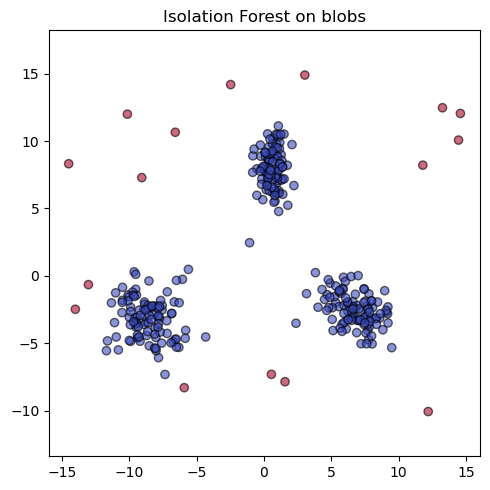

In [14]:
# Test run to visualize a random set
anom_detector = IsolationForest(contamination=0.05, random_state=42)
y_pred = anom_detector.fit_predict(blob_data)
plot_isolation_forest(blob_data, y_pred, "Isolation Forest on blobs")

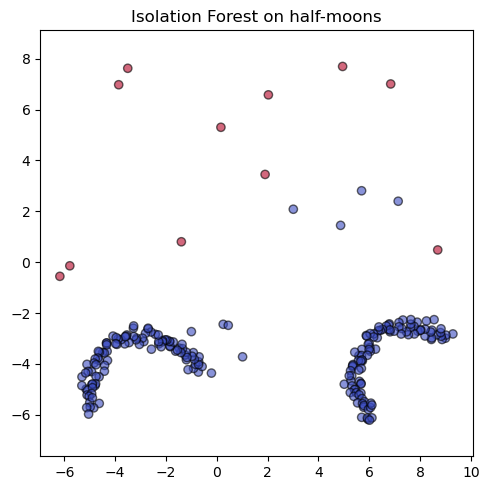

In [15]:
anom_detector = IsolationForest(contamination=0.05, random_state=2)
y_pred = anom_detector.fit_predict(moon_data)
plot_isolation_forest(moon_data, y_pred, "Isolation Forest on half-moons")